In [1]:
import pandas as pd
import torch 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision

/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#fix the seed
torch.manual_seed(0)
np.random.seed(0)

In [3]:
train_img_csv = pd.read_csv('train_predictions_img.csv')
train_tab_csv = pd.read_csv('train_hm_tab_cluster.csv')
test_tab_csv = pd.read_csv('test_hm_tab_cluster.csv')
test_img_csv = pd.read_csv('test_predictions_img.csv')

In [4]:
df = pd.read_csv('data/h&mdataset/articles.csv')
df = df.drop(columns=['prod_name','product_code','department_no', 'index_code', 	
       'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc'])

In [5]:
df

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no
0,108775015,253,1010016,9,4,5,1,16,1002
1,108775044,253,1010016,10,3,9,1,16,1002
2,108775051,253,1010017,11,1,9,1,16,1002
3,110065001,306,1010016,9,4,5,1,61,1017
4,110065002,306,1010016,10,3,9,1,61,1017
...,...,...,...,...,...,...,...,...,...
105537,953450001,302,1010014,9,4,5,3,26,1021
105538,953763001,253,1010016,9,4,5,1,2,1005
105539,956217002,265,1010016,9,4,5,1,18,1005
105540,957375001,72,1010016,9,4,5,2,52,1019


In [6]:
test_img_csv

,image,cluster
0,075/0759974004.jpg,129
1,080/0808882004.jpg,129
2,074/0744306009.jpg,129
3,075/0754018003.jpg,129
4,087/0878972002.jpg,129
...,...,...
1995,053/0537346013.jpg,129
1996,074/0743225001.jpg,129
1997,057/0571319003.jpg,129
1998,070/0706656001.jpg,129


In [7]:
#find common points in test img and tab

common_points = pd.merge(test_img_csv, test_tab_csv, left_on='image', right_on='img_name', how='inner')

In [8]:
common_points

,image,cluster_x,Unnamed: 0,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no,cluster_y,img_name
0,068/0682604001.jpg,129,45252,682604001,265,1010001,9,4,5,2,53,1013,264,068/0682604001.jpg
1,066/0663384001.jpg,129,40039,663384001,87,1010016,17,4,13,3,27,1020,264,066/0663384001.jpg
2,080/0805708002.jpg,129,81431,805708002,274,1010014,7,1,12,4,77,1005,264,080/0805708002.jpg
3,067/0677446001.jpg,129,43520,677446001,94,1010004,42,7,18,3,24,1001,264,067/0677446001.jpg
4,075/0759068001.jpg,129,69969,759068001,265,1010017,71,3,2,1,15,1003,264,075/0759068001.jpg
5,079/0796599001.jpg,129,79119,796599001,265,1010015,12,1,11,2,58,1013,264,079/0796599001.jpg
6,079/0798300005.jpg,129,79555,798300005,59,1010001,51,1,4,4,44,1019,264,079/0798300005.jpg
7,091/0915526002.jpg,129,103794,915526002,252,1010016,9,4,5,1,15,1003,264,091/0915526002.jpg
8,066/0663568001.jpg,129,40132,663568001,275,1010004,9,4,5,1,11,1012,264,066/0663568001.jpg
9,056/0568943002.jpg,129,16174,568943002,275,1010016,19,4,20,1,11,1012,264,056/0568943002.jpg


In [9]:
#Choose a random common point
common_point = common_points.sample()
#Get its cluster for tabular model

cluster_common_point_tab = common_point['cluster_y'].values[0]
cluster_common_point_img = common_point['cluster_x'].values[0]

In [10]:
cluster_common_point_tab

264

In [11]:
#get all the points in the same cluster for tabular model
same_cluster_points_tab = test_tab_csv[test_tab_csv['cluster'] == cluster_common_point_tab]

#get all the points in the same cluster for image model
same_cluster_points_img = test_img_csv[test_img_csv['cluster'] == cluster_common_point_img]

In [12]:
same_cluster_points_tab

,Unnamed: 0,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no,cluster,img_name
0,17149,573085005,272,1010023,73,2,2,1,15,1009,264,057/0573085005.jpg
1,89149,836367002,275,1010016,13,2,11,1,15,1012,264,083/0836367002.jpg
2,85414,819520001,254,1010016,9,4,5,1,16,1002,264,081/0819520001.jpg
3,57119,715819002,262,1010001,73,4,2,4,45,1007,264,071/0715819002.jpg
4,2264,399256037,272,1010023,11,1,9,1,15,1009,264,039/0399256037.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,46036,685226001,265,1010016,73,4,2,4,76,1014,264,068/0685226001.jpg
1996,99615,885806001,253,1010016,9,4,5,1,16,1002,264,088/0885806001.jpg
1997,2875,436570033,66,1010016,22,7,8,1,65,1019,264,043/0436570033.jpg
1998,7347,513007001,78,1010001,2,3,9,1,66,1019,264,051/0513007001.jpg


In [13]:
#calculate jaccard similarity

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

jaccard_similarity(same_cluster_points_tab['img_name'], same_cluster_points_img['image'])

0.00806654902949332

In [14]:
#get the rows of df from same_cluster_points_tab

df_common_points_tab = df[df['article_id'].isin(same_cluster_points_tab['article_id'])]

In [15]:
df_common_points_tab

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no
45,145872053,252,1010010,8,4,12,26,22,1005
340,224314007,75,1010016,9,4,5,1,65,1019
349,224521007,273,1010016,9,4,5,26,22,1005
367,228257001,304,1010016,9,4,5,1,62,1021
420,237347060,308,1010010,7,2,12,1,16,1002
...,...,...,...,...,...,...,...,...,...
104939,929001001,265,1010016,92,2,20,1,15,1013
104972,929609001,72,1010016,5,5,15,1,66,1019
105020,930533003,302,1010016,7,2,12,1,62,1021
105027,930829001,70,1010016,5,5,15,1,66,1019


In [16]:
#Do a KNN for the common point on the tabular data

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(df_common_points_tab)
distances, indices = neigh.kneighbors(df_common_points_tab, 5)

In [17]:
if len(indices) > 1:
    indices = indices[0]

imgs_path_tab = same_cluster_points_tab.iloc[indices]['img_name']

In [18]:
imgs_tab = [plt.imread('data/h&mdataset/images/' + img_path) for img_path in imgs_path_tab]

In [19]:
class ResNet(nn.Module):
    def __init__(self, num_classes=132):
        super(ResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.fc = nn.Linear(2048, num_classes)
        self.resnet.eval()
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.fc.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)

resnet_model = ResNet()
model_ft_path = 'models/resnet_finetuned.pth'
if os.path.exists(model_ft_path):
    resnet_model.load_state_dict(torch.load(model_ft_path))
    print('ResNet model loaded')
else:
    print('No fintuned model found, Resnet pretrained model will be used')



Using cache found in /Users/jskaf/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet model loaded


In [20]:
preprocess = torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms()

In [21]:
same_cluster_points_img

,image,cluster
0,075/0759974004.jpg,129
1,080/0808882004.jpg,129
2,074/0744306009.jpg,129
3,075/0754018003.jpg,129
4,087/0878972002.jpg,129
...,...,...
1995,053/0537346013.jpg,129
1996,074/0743225001.jpg,129
1997,057/0571319003.jpg,129
1998,070/0706656001.jpg,129


In [22]:
#load imgs from the path of same_cluster_points_img
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

imgs = []
path = os.getcwd() + '/data/h&mdataset/images/'
for img_path in tqdm(same_cluster_points_img['image']):
        img = Image.open(path + img_path)
        img = transforms.Pad(padding=256)(img)
        img = preprocess(img)
        imgs.append(img)


100%|██████████| 1999/1999 [00:47<00:00, 42.01it/s]


In [23]:
#Do a KNN for the common point on the image data

#transform the images into their resnet embeddings

imgs = [resnet_model(img.unsqueeze(0)) for img in imgs]
imgs = [img.detach().numpy() for img in imgs]
imgs


[array([[[[0.13483779]],
 
         [[0.45662612]],
 
         [[0.19253795]],
 
         ...,
 
         [[0.17036633]],
 
         [[0.09875621]],
 
         [[0.16045894]]]], dtype=float32),
 array([[[[0.7294612 ]],
 
         [[1.4854288 ]],
 
         [[0.31082857]],
 
         ...,
 
         [[0.2741001 ]],
 
         [[1.6052095 ]],
 
         [[0.06138923]]]], dtype=float32),
 array([[[[0.2328964 ]],
 
         [[0.4545883 ]],
 
         [[0.47147506]],
 
         ...,
 
         [[0.14606917]],
 
         [[0.04557503]],
 
         [[0.15677407]]]], dtype=float32),
 array([[[[0.23051351]],
 
         [[1.0603484 ]],
 
         [[0.39189833]],
 
         ...,
 
         [[0.21658635]],
 
         [[0.01220719]],
 
         [[0.20229417]]]], dtype=float32),
 array([[[[0.5484458 ]],
 
         [[0.8094886 ]],
 
         [[0.03785137]],
 
         ...,
 
         [[0.4004829 ]],
 
         [[0.2658433 ]],
 
         [[0.14331326]]]], dtype=float32),
 array([[[[0.5440479 ]],
 
   

In [24]:
embeddings = [img.flatten() for img in imgs]
embeddings = np.array(embeddings)

In [25]:
if len(embeddings) > 1:
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(embeddings)
    distances, indices = neigh.kneighbors(embeddings, 5)
else:
    print('No similar images found')

In [26]:
if len(indices) > 1:
    indices = indices[0]

imgs_path_resnet = same_cluster_points_img.iloc[indices]['image']

In [27]:
imgs_path_resnet

0       075/0759974004.jpg
1547    068/0681796007.jpg
388     089/0898410002.jpg
1367    068/0685185001.jpg
1462    054/0546807005.jpg
Name: image, dtype: object

In [28]:
#Get the image of the common point
imgs_resnet = [plt.imread('data/h&mdataset/images/' + img_path) for img_path in imgs_path_resnet]

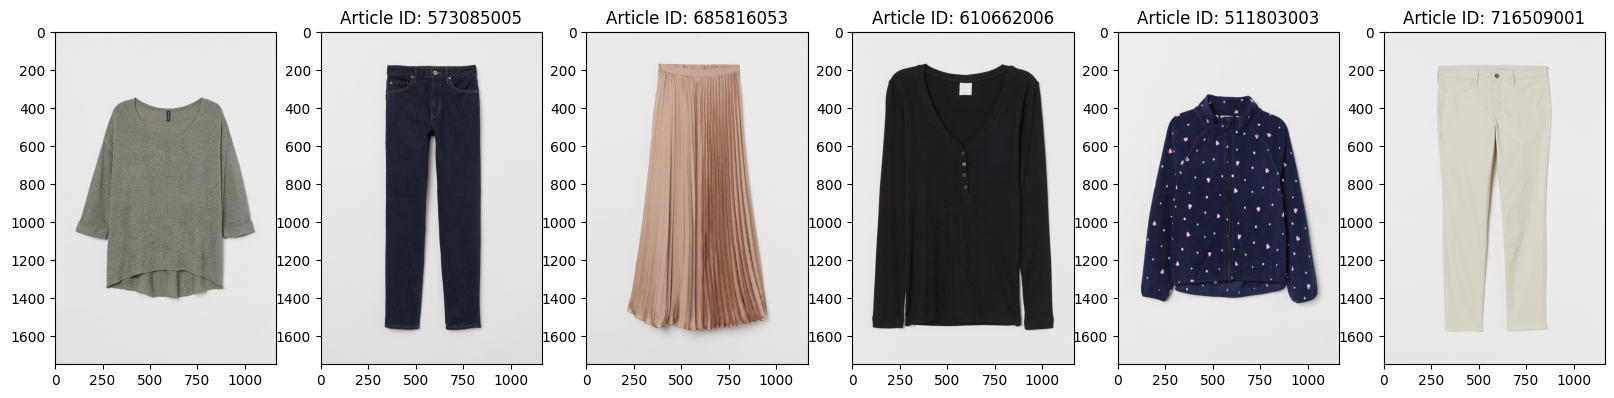

In [31]:
#Plot the images for tabular data

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(20, 20))
#plot the common point image
axs[0].imshow(plt.imread('data/h&mdataset/images/' + common_point['image'].values[0]))

for i, img in enumerate(imgs_tab):
    axs[i+1].imshow(img)
    axs[i+1].set_title('Article ID: ' + str(same_cluster_points_tab.iloc[indices]['article_id'].values[i]))

plt.show()


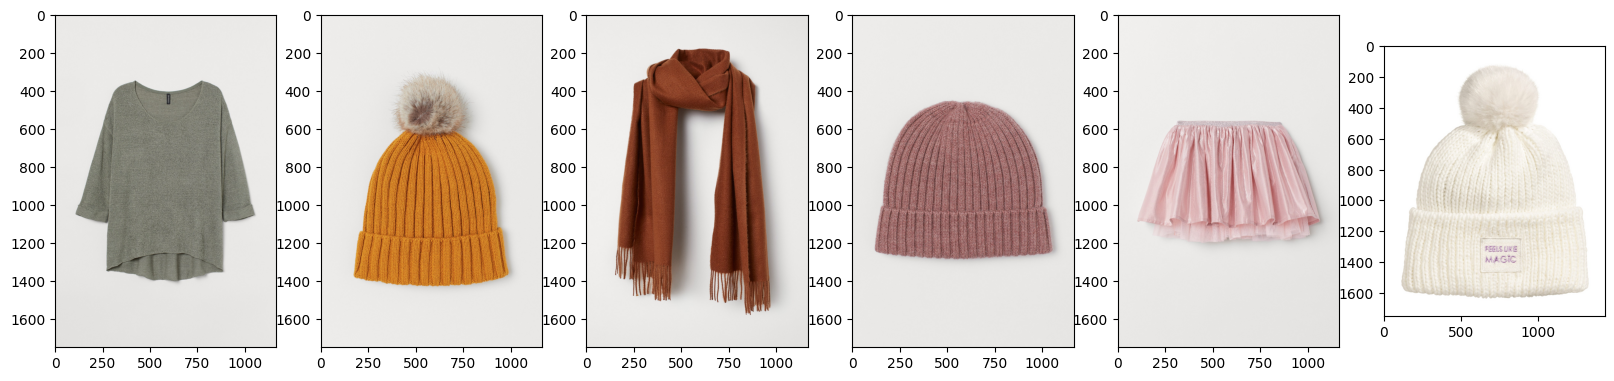

In [33]:
#Plot the images for image data

fig, axs = plt.subplots(1, 6, figsize=(20, 20))
#plot the common point image
axs[0].imshow(plt.imread('data/h&mdataset/images/' + common_point['image'].values[0]))

for i, img in enumerate(imgs_resnet):
    axs[i+1].imshow(img)

plt.show()